# Introduction

This is a Datapane report that demonstrates working with SQL databases, such as `sqlite`, `duckdb`, or data warehouses like `AWS RDS`.

One of the most important skills for data analysis is interacting with databases. Most organizations store their business-critical data in a relational database like Postgres or MySQL, and you’ll need to know Structured Query Language (SQL) to access or update the data stored there.

SQL is an incredible language — it was invented in the 1970s and most new database projects e.g. Redshift, Snowflake, CockroachDB still choose it as their foundation because it is powerful and relatively simple (at least to start). And while it excels at retrieving data, you usually need an enterprise Business Intelligence platform like Tableau or Looker to visualize the results.
In this article, I’ll show you how to combine SQL and open-source Python libraries to build an interactive dashboard on the web — see a live version here, and the code on Github. This is a great technique to quickly prototype applications using a database.

# The dataset

We’ll use a well-known open-source dataset called Chinook, which stores data about purchases at a small music shop over several years. This data is stored as a SQLite database inside a single file, so we can query it directly from our local Python environment without access credentials.
Here’s a quick table showing the database schema:
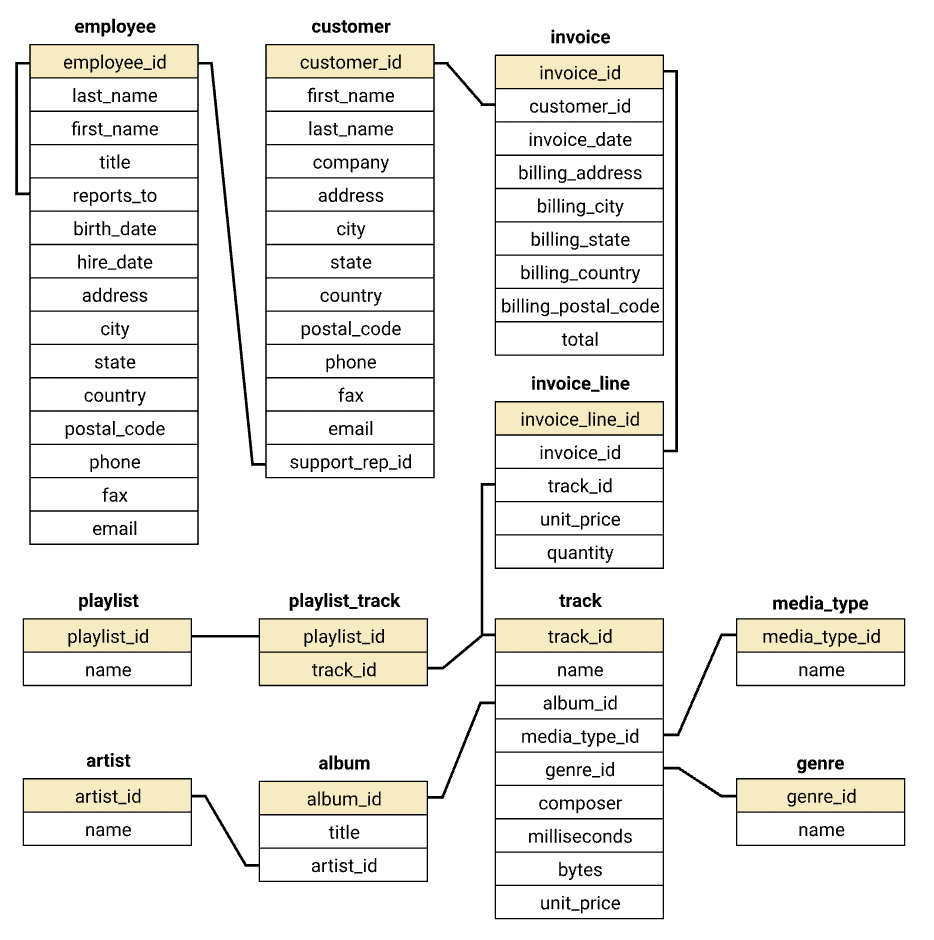
If you’re coming from Pandas and aren’t familiar with database schema, here are a few pointers:
- The database is split into separate tables which represent different logical objects. For example, all the customers are in the customer database. This is unlike the traditional Pandas dataframe, which is usually just a single table.
- Each table has a set of fields, which define the attributes of the table, and rows, which store the actual data. These are just like columns and rows in Excel.
- Relationships between tables are represented by special fields called foreign keys. For example, each track has an album_id which links to the album table, meaning every track is part of an album. When we query the database, we’ll often join different tables together on their foreign keys.
Connecting to the database
We’ll start off by defining some helper functions for connecting to the database:

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import datapane as dp

In [ ]:
# DB based on https://github.com/lerocha/chinook-database/blob/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite
db = "chinook.db"


def run_query(q: str) -> pd.DataFrame:
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)


def run_command(c: str):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

In [ ]:
def show_tables() -> pd.DataFrame:
    q = """
        SELECT
            name
        FROM sqlite_master
        WHERE type IN ("table","view");
        """
    return run_query(q)


def get_table_row_count(tablename) -> int:
    q = (
        """
        SELECT
            COUNT(1)
        FROM %s;
        """
        % tablename
    )
    return run_query(q)["COUNT(1)"][0]


tables = show_tables()
tables["row_count"] = [get_table_row_count(t) for t in tables["name"]]

tables

As you can see, we write the SQL query as a string and then execute it within a Python function. It’s a little awkward to mix two different languages together like this, but works surprisingly well once you get the hang of it! Running the code above gives all the different table names in the database and the number of rows in each table. 

# Building a dashboard
So, let’s imagine you just started as a data scientist at Chinook, and your boss wants to know the best-selling tracks so they can promote them on the website. To answer this question, we’ll need to write a query like this:


In [ ]:
import datapane as dp

top_10_tracks_query = """
SELECT 
    t.name trackname,
    a.title album_title,
    ar.name artist,
    COUNT(*) as total_purchases,
    SUM(il.UnitPrice) total_cost
FROM Track t 
JOIN Album a on a.AlbumId = t.AlbumId
JOIN Artist ar on ar.ArtistId = a.ArtistId
JOIN InvoiceLine il on il.TrackId = t.TrackId
GROUP BY 1
ORDER BY total_purchases desc
LIMIT 10
"""

top_10_df = run_query(top_10_tracks_query)

dp.DataTable(top_10_df)

We start by selecting the columns we want to see in the output. Since these come from four different tables (track, album, artist, invoice_line), we need to join the tables on the foreign key relationships — check the schema to see what is possible. 

Next we group by the track name, order by the most purchases and only select the top 10 results.
Running the query gives us a pandas dataframe, which we then wrap in a DataTable block.

# More complex queries
Flush with our recent success, the boss asks us a more complex question — “Who are our best-performing sales employees, and when do they make the most sales?”
Instead of answering this question with tables, we can use a Python visualization library like Plotly to build more satisfying interactive charts:

In [ ]:
employee_sales_performance = """
WITH 
    customer_support_rep_sales AS
        (
         SELECT 
             i.CustomerId,
             strftime('%Y-%m', i.InvoiceDate) || "-01" Month,
             c.SupportRepId,
             SUM(i.Total) Sales_Total
         FROM Invoice i
         INNER JOIN Customer c ON c.CustomerId = i.CustomerId
         GROUP BY 2, 3
        )
SELECT
    e.FirstName || " " || e.LastName "Employee Name",
    csrs.Month,
    SUM(csrs.Sales_total) "Amount of Sales (in $)"
FROM customer_support_rep_sales csrs
INNER JOIN Employee e ON csrs.SupportRepId = e.EmployeeId
GROUP BY 1, 2;
"""

run_query(employee_sales_performance)

This query is significantly more complex than the previous one:
- We use strftime to truncate the timestamps so we can group by month. This makes the data look nicer when we plot it.
- We use a subquery (also called a Common Table Expression) to calculate an intermediate table (customer_support_rep_sales). We then call this table in the final query.
- Some operations can be done in either Pandas or SQL — for example we did a groupby in pandas to remove the ‘Month’ column for the second chart. I prefer doing the most complex joins and groupings in SQL and just using Python to format the results if necessary.

Running the code above gives us the following result:

In [ ]:
employee_sales = run_query(employee_sales_performance)
employee_sales["Month"] = pd.to_datetime(employee_sales["Month"])

employee_sales_monthly = px.line(employee_sales, x="Month", y="Amount of Sales (in $)", color="Employee Name")

employee_sales_monthly.update_layout(legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01))

employee_sales_monthly.show()

In [ ]:
employee_sales_total = (
    employee_sales.groupby(["Employee Name"]).sum().sort_values(by="Amount of Sales (in $)").reset_index()
)

employee_sales_bar = px.bar(
    employee_sales_total, y="Employee Name", x="Amount of Sales (in $)", text="Amount of Sales (in $)", orientation="h"
)

employee_sales_bar.update_traces(texttemplate="%{text:.1f}")
employee_sales_bar.show()

## Selecting Albums to Purchase

We'll now calculate a few additional metrics to fill out the dashboard, like top genres

In [ ]:
albums_to_purchase = """
WITH 
    usa_tracks_sold AS
        (
         SELECT il.* FROM InvoiceLine il
         INNER JOIN Invoice i ON il.InvoiceId = i.InvoiceId
         INNER JOIN Customer c ON i.CustomerId = c.CustomerId
        )
SELECT 
    g.name Genre, 
    COUNT(uts.InvoiceLineId) "Number of Tracks Sold", 
    CAST(COUNT(uts.InvoiceLineId) AS FLOAT)/(SELECT COUNT(*) FROM usa_tracks_sold) "Percentage of Tracks Sold"
FROM usa_tracks_sold uts
INNER JOIN Track t ON uts.TrackId = t.TrackId
INNER JOIN Genre g ON t.GenreId = g.GenreId
GROUP BY 1 
ORDER BY 2 DESC
LIMIT 10;
"""

genre_sales = run_query(albums_to_purchase)
genre_sales.sort_values("Number of Tracks Sold", inplace=True)

genre_sales_plot = px.bar(
    genre_sales,
    x="Percentage of Tracks Sold",
    y="Genre",
    orientation="h",
    text="Percentage of Tracks Sold",
    title="Sales by Genre",
)

genre_sales_plot.update_traces(texttemplate="%{text:.1%}", textposition="outside")

genre_sales_plot.show()

Based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:

- Red Tone (Punk)
- Slim Jim Bites (Blues)
- Meteor and the Girls (Pop)

It's worth keeping in mind that combined, these three genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales.

## Analyzing Sales by Country

Our next task is to analyze the sales data for customers from each different country. We have been given guidance to use the country value from the `customers` table, and ignore the country from the billing address in the `invoice` table.

In particular, you have been directed to calculate data, for each country, on the:

- total number of customers
- total value of sales
- average value of sales per customer
- average order value

Because there are a number of countries with only one customer, we should group these customers as "Other" in our analysis.

In [ ]:
sales_by_country = """
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM Customer
                 where Country = c.Country
                ) = 1 THEN "Other"
           ELSE c.Country
       END AS country,
       c.CustomerId,
       il.*
     FROM InvoiceLine il
     INNER JOIN Invoice i ON i.InvoiceId = il.InvoiceId
     INNER JOIN Customer c ON c.CustomerId = i.CustomerId
    )


SELECT
    Country,
    count(distinct CustomerId) customers,
    SUM(UnitPrice) total_sales,
    SUM(UnitPrice) / count(distinct CustomerId) customer_lifetime_value,
    SUM(UnitPrice) / count(distinct InvoiceId) average_order,
    CASE
        WHEN country = "Other" THEN 1
        ELSE 0
    END AS sort
FROM country_or_other
GROUP BY country
ORDER BY sort ASC, total_sales DESC;
"""

run_query(sales_by_country)

## Visualizing Sales by Country

Now that we have our data, we've been asked to create a series of visualizations which communicate our findings, and then make recommendations on which countries may have potential for growth, so the Chinook marketing team can create some new advertising campaigns.

In [ ]:
country_metrics = run_query(sales_by_country)

sales_breakdown = go.Figure(
    data=[go.Pie(labels=country_metrics["country"], values=country_metrics["total_sales"], hole=0.3)]
)

sales_breakdown.update_layout(title_text="Sales by country")

sales_breakdown.show()

In [ ]:
customer_ratio = country_metrics["customers"] / country_metrics["customers"].sum() * 100.0
sales_ratio = country_metrics["total_sales"] / country_metrics["total_sales"].sum() * 100.0


custs_vs_dollars = go.Figure(
    data=[
        go.Bar(name="Customers", x=country_metrics["country"], y=customer_ratio),
        go.Bar(name="Total Sales", x=country_metrics["country"], y=sales_ratio),
    ]
)

# Change the bar mode
custs_vs_dollars.update_layout(barmode="group", title_text="Pct customers vs sales")
custs_vs_dollars.show()

In [ ]:
country_metrics["difference_from_avg"] = (
    country_metrics["average_order"] - country_metrics["average_order"].mean()
) * 100.0

avg_order = px.bar(
    country_metrics,
    x="country",
    y="difference_from_avg",
    color="country",
    title="Avg order - Pct difference from mean",
    labels={"country": "Country", "difference_from_avg": "Difference from mean (%)"},
)

avg_order.update_layout(showlegend=False)

avg_order.show()

In [ ]:
clv = px.bar(
    country_metrics,
    x="country",
    y="customer_lifetime_value",
    color="country",
    labels={"country": "Country", "customer_lifetime_value": "Customer Lifetime Value ($)"},
    title="Customer Lifetime Value",
)
clv.update_layout(showlegend=False)
clv.show()

# Putting it into a Datapane report

Now that we have all our charts defined, we can combine them together into a Datapane report. We'll use Groups to add charts in a grid layout, as well as BigNumbers, Plots and DataTables. 

In [ ]:
customers = tables[tables["name"] == "Customer"]["row_count"].values[0]
employees = tables[tables["name"] == "Employee"]["row_count"].values[0]
tracks_sold = tables[tables["name"] == "InvoiceLine"]["row_count"].values[0]

In [ ]:
r = dp.Blocks(
    dp.Group(
        dp.BigNumber(heading="Total customers", value=customers),
        dp.BigNumber(heading="Total employees", value=employees),
        dp.BigNumber(heading="Total tracks sold", value=tracks_sold),
        columns=3,
        name="Little_group",
    ),
    dp.Plot(genre_sales_plot, name="genre_sales"),
    dp.Plot(employee_sales_monthly, name="employee-sales-1"),
    dp.Plot(employee_sales_bar, name="employee-sales-2"),
    dp.Group(dp.Plot(sales_breakdown), dp.Plot(custs_vs_dollars), dp.Plot(avg_order), dp.Plot(clv), columns=2),
    dp.DataTable(top_10_df, name="track-sales"),
)

dp.save_report(r, "report.html", open=True)

import os
if os.getenv("DATAPANE_DEPLOY") == "1":
    dp.upload_report(r, name="Interactive Dashboard using SQL")